# データ分析の実践

In [24]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot  as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error

In [ ]:
# Colaboratoryでは以下を実行して必要なファイルをダウンロード
!wget https://raw.githubusercontent.com/UTDataMining/2020A/master/1214/winequality-red.csv

## データセットの準備
以下では、UCI Machine Learning Repositoryに公開されているワインの品質データセットを用いて、ワインの理化学検査結果に基づく特徴量からワインの品質を予測することを考えます。

データセットには赤ワインのデータセットと白ワインのデータセットが含まれますが、以下では赤ワインのデータセットを使用します。

[Wine Quality Data Set ](https://archive.ics.uci.edu/ml/datasets/wine+quality)

各ワインのデータは以下の11種類の特徴量からなります。
- 1 - fixed acidity 
- 2 - volatile acidity 
- 3 - citric acid 
- 4 - residual sugar 
- 5 - chlorides 
- 6 - free sulfur dioxide 
- 7 - total sulfur dioxide 
- 8 - density 
- 9 - pH 
- 10 - sulphates 
- 11 - alcohol 

また、各ワインには0から10の品質スコアが付与さています。11種類の特徴量を元にワインの品質スコアを回帰することでワインの品質を予測することを考えます。

## データの観察
まず、データセットを読み込みます。ここではデータセットのcsvファイルを`pandas`のデータフレームとして読み込みます。

In [25]:
wine = pd.read_csv("winequality-red.csv", sep=";")

読み込んだデータセットのデータフレームの情報を確認してみます。1599のデータを行、11の特徴量と1つの品質スコアを列とするデータフレームとなっています。欠損値は含まれていないようです。

In [26]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


データセットを表示してみます。各特徴量と品質スコアは数値で表されていることがわかります。

In [27]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


各特徴量と品質スコアの記述統計を観察してみます。

In [28]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


`pandas`のデータフレームの可視化関数を使って各特徴量ごと値の分布を可視化してみます。

それぞれの特徴量はどのような分布になっているでしょうか。また、外れ値や特徴量の変換処理は必要でしょうか（以下では外れ値の処理を行わずに進めることとします）。

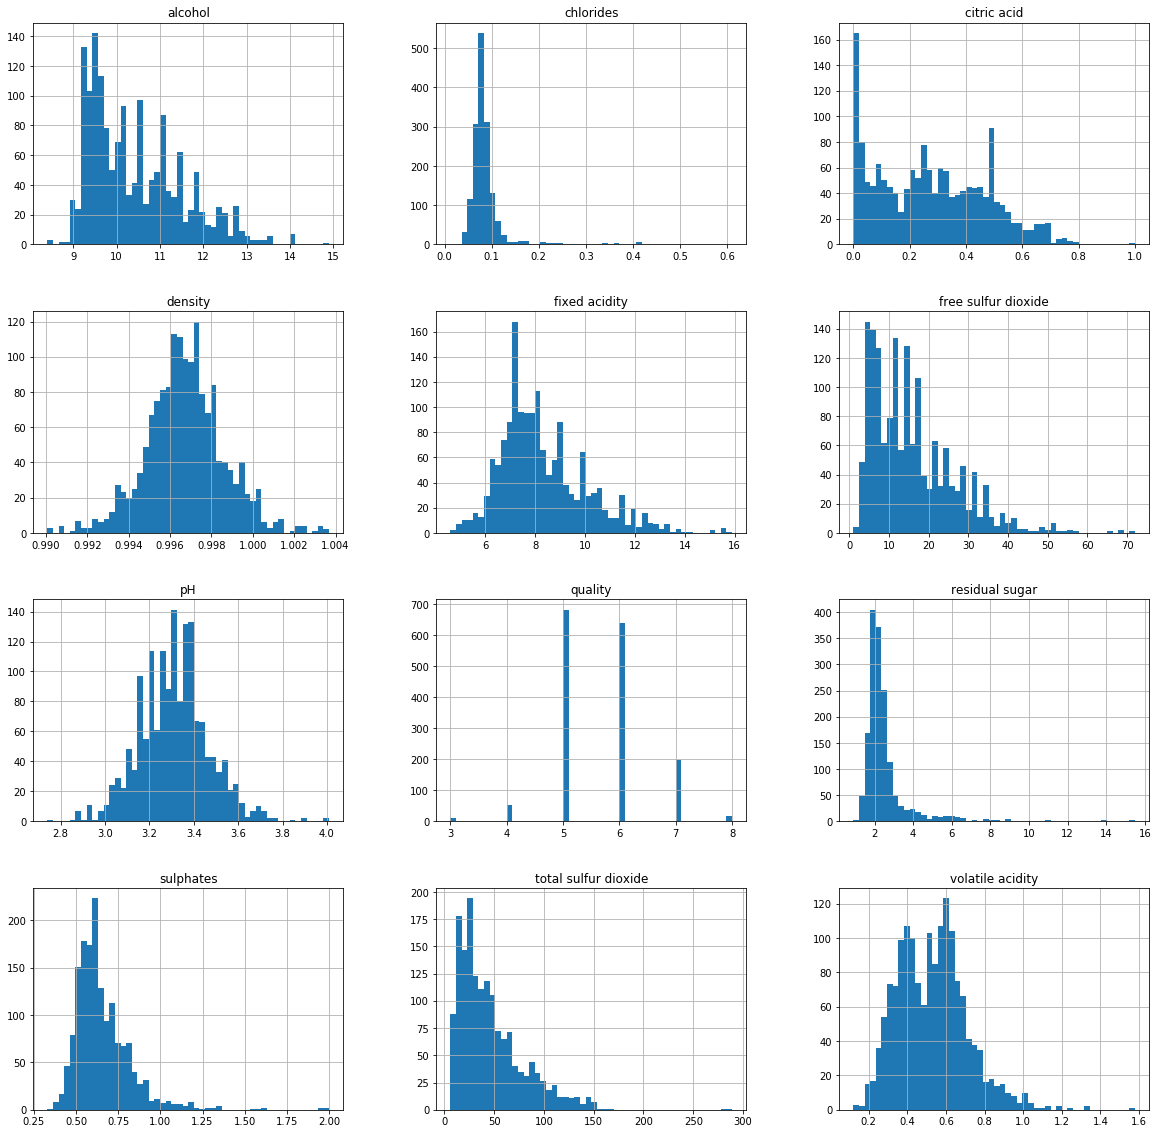

In [29]:
wine.hist(bins=50, figsize=(20,20));

品質スコアごとのデータ数を数えると多くのデータの品質は5または6となっています。

In [30]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

`pandas`のデータフレームの`corr`メソッドを用いて、特徴量間および各特徴量と品質スコアの相関を計算してみます。 お互いに相関がある特徴量、品質スコアと相関がある特徴量はあるでしょうか。

In [31]:
wine.corr(method='pearson')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


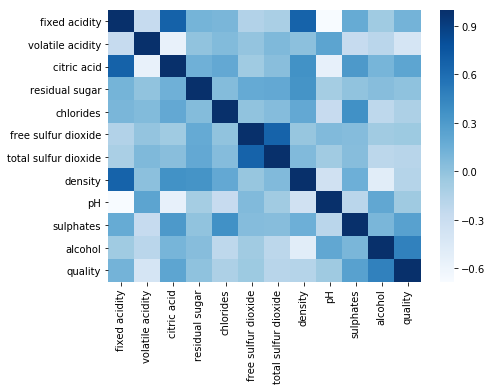

In [32]:
plt.figure(figsize=(7,5))
sns.heatmap(wine.corr(method='pearson'), cmap='Blues');

品質スコア'quiality'と特徴量'alcohol'には非常に緩やかな正の相関があることがわかります。

In [33]:
corr=wine.corr(method='pearson')
corr["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

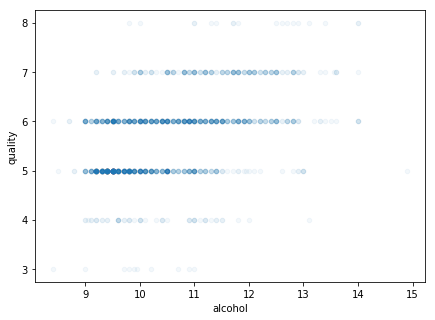

In [34]:
wine.plot(kind="scatter", x="alcohol", y="quality", alpha=0.05, figsize=(7,5));

## モデルの学習
### 線形回帰
特徴量'alcohol'から品質スコアを予測するモデルを学習することを考えます。以下では、データセットの70%をモデル学習の訓練データ、30%をモデル評価のテストデータに分割し、特徴量を標準化した上で線形回帰によるモデルの学習を行っています。学習したモデルをテストデータに適用して予測を行い、平均二乗誤差によりモデルの精度を評価しています。

In [38]:
X=wine[['alcohol']].values
y=wine[['quality']].values

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# 線形回帰
lr = LinearRegression()
lr=lr.fit(X_train, y_train)

# 予測
mse=mean_squared_error(y_test,lr.predict(X_test))
print('テストデータ誤差 '+'{:.3f}'.format(mse))

テストデータ誤差 0.516


次に、すべての特徴量から品質スコアを予測するモデルを学習することを考えます。手順は上記と同じです。特徴量をすべて用いることでテストデータの誤差は小さくなっています。

In [39]:
X=wine[ ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values
# X=wine.drop("quality", axis=1).values
y=wine[['quality']].values

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# 線形回帰
lr = LinearRegression()
lr=lr.fit(X_train, y_train)

# 予測
mse=mean_squared_error(y_test,lr.predict(X_test))
print('テストデータ誤差 '+'{:.3f}'.format(mse))

テストデータ誤差 0.401


LinerRegression()オブジェクトのcoef_属性で学習された特徴量の重み（係数）を調べることができます。どの特徴量が予測に有効であると言えるでしょうか。

In [40]:
pd.DataFrame(lr.coef_, index=['weight'], columns=wine.drop("quality", axis=1).columns.values)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
weight,0.086582,-0.175892,-0.039447,0.04955,-0.099793,0.037534,-0.102417,-0.07465,-0.049988,0.158645,0.281997


### 学習曲線
学習に用いるデータを徐々に増やした時の訓練データの誤差とテストデータ（以下では交差検証による検証データ）の誤差を以下のように学習曲線としてプロットしてみます。データを増やすとテストデータの誤差は徐々に減少していきますが、訓練データとの誤差にやや差があることがわかります。

以下のコードでは`make_pipeline`で標準化の処理と線形回帰モデルをまとめています。

[make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

`learning_curve`は`train_sizes`引数で指定された分のデータを利用して交差検証（`cv`引数でfold数を指定）によりモデルの評価を行い、訓練データと検証データの予測精度（`scoring`引数で評価指標を指定）をそれぞれ返します。以下では評価指標として`neg_mean_squared_error`を使用しています。

[learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)

[scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html)

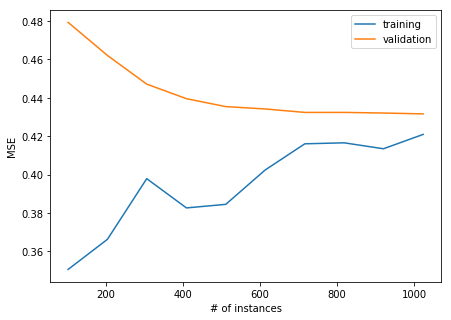

In [41]:
# 標準化と線形回帰モデルのパイプライン
pipe=make_pipeline(StandardScaler(), LinearRegression())

# 学習曲線
training_sizes, train_scores, valid_scores = learning_curve(pipe, X_train, y_train, cv=5,
                                                scoring="neg_mean_squared_error",
                                                train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure(figsize=(7,5))
plt.xlabel('# of instances')
plt.ylabel('MSE')
plt.plot(training_sizes, -train_scores.mean(axis=1), label="training")
plt.plot(training_sizes, -valid_scores.mean(axis=1), label="validation")
plt.legend();

##  モデル選択と評価
### 多項式
モデルを複雑にした時のモデル選択と評価について考えます。以下では、多項式により入力の特徴量を増やしモデルを複雑にしています。多項式の次数を増やすと訓練データの誤差は減少していきますが検証データの誤差は3次の多項式で急激に増加し、過学習がおこっていることがわかります。

`validation_curve`は`param_name`引数で指定されたハイパーパラメータ（ここでは多項式の次数）について`param_range`引数で指定した値ごとに交差検証（`cv`引数でfold数を指定）によりモデルの評価を行い、各交差検証の訓練データと検証データの予測精度（`scoring`引数で指標を指定）を返します。

[validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)

In [42]:
X=wine.drop("quality", axis=1).values
y=wine[['quality']].values

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

訓練データ誤差（次数:1,2,3） [0.42088113 0.3696442  0.20538746]
検証データ誤差（次数:1,2,3） [0.43163512 0.46101961 5.63512852]


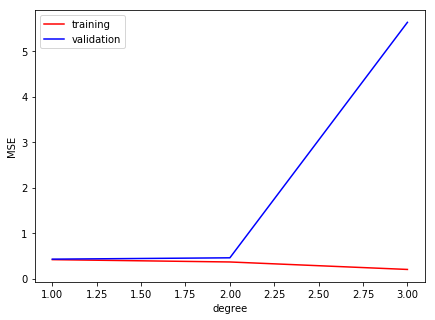

In [43]:
# 多項式特徴量と標準化と線形回帰モデルのパイプライン
pipe=make_pipeline(PolynomialFeatures(), StandardScaler(), LinearRegression())

# 次数
degree = [1, 2, 3]

# バリデーション曲線
train_scores, valid_scores = validation_curve(pipe, X_train, y_train, 
                                              param_name='polynomialfeatures__degree',  param_range=degree, 
                                              scoring="neg_mean_squared_error", cv=5)

print('訓練データ誤差（次数:1,2,3）',-train_scores.mean(axis=1)) # 訓練データの誤差
print('検証データ誤差（次数:1,2,3）',-valid_scores.mean(axis=1)) # 検証データの誤差

plt.figure(figsize=(7,5))
plt.xlabel('degree')
plt.ylabel('MSE')
plt.plot(degree, -train_scores.mean(axis=1), color='red', label='training')
plt.plot(degree, -valid_scores.mean(axis=1), color='blue', label='validation')
plt.legend();

### 正則化
多項式の次数を3次にした時、検証データの誤差が急激に増加し過学習がおこることを確認しました。ここで、正則化を用いて過学習を抑えることを考えます。以下では、$L_2$ノルムを正則化に用いた線形回帰モデルである`Ridge`（リッジ回帰）を用いています。正則化項の係数を大きくすると、検証データの誤差が減少し、過学習が抑えられていることがわかります。一方、正則化項の係数を大きくすると、訓練データの誤差は徐々に増加していることがわかります。

訓練データ誤差（正則化係数ごと） [0.24598596 0.26159571 0.28539547 0.3175113  0.35316016 0.38079705
 0.40125317]
検証データ誤差（正則化係数ごと） [2.28813107 0.91754593 0.57851023 0.54230677 0.45740028 0.42301501
 0.41984357]


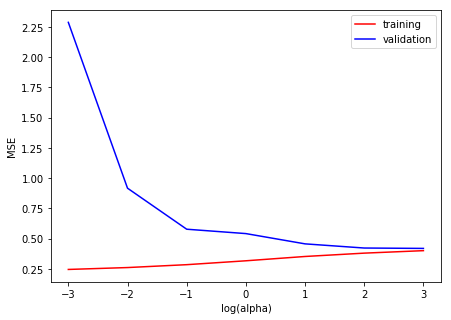

In [44]:
# 標準化と多項式特徴量（3次）とリッジ回帰モデルのパイプライン
pipe=make_pipeline(PolynomialFeatures(degree=3), StandardScaler(), Ridge())

# 正則化項の係数
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# バリデーション曲線
train_scores, valid_scores = validation_curve(pipe, X_train, y_train, 
                                              'ridge__alpha', alpha, 
                                              cv=5, scoring="neg_mean_squared_error")

print('訓練データ誤差（正則化係数ごと）',-train_scores.mean(axis=1)) # 訓練データの誤差
print('検証データ誤差（正則化係数ごと）',-valid_scores.mean(axis=1)) # 検証データの誤差

plt.figure(figsize=(7,5))
plt.xlabel('log(alpha)')
plt.ylabel('MSE')
plt.plot(np.log10(alpha), -train_scores.mean(axis=1), color='red', label='training')
plt.plot(np.log10(alpha), -valid_scores.mean(axis=1), color='blue', label='validation')
plt.legend();

以下は、多項式の次数を2次にした時の正則化項の係数と誤差です。正則化項の係数を大きくすると検証データの誤差が減少しますが、大きくしすぎると、訓練データの誤差も検証データの誤差も増加するアンダーフィティング（High Bias）の状態になります。

訓練データ誤差（正則化係数ごと） [0.37415106 0.3751812  0.37556577 0.37819839 0.38516598 0.3987686
 0.42079551]
検証データ誤差（正則化係数ごと） [0.45199162 0.45179353 0.44845027 0.43880609 0.42287278 0.41798959
 0.43180823]


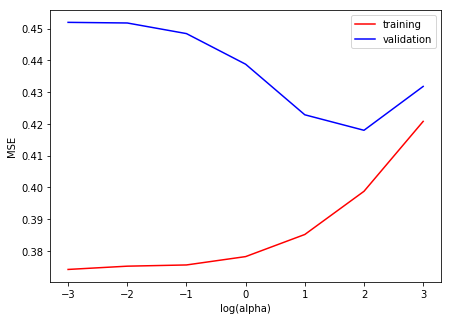

In [45]:
# 標準化と多項式特徴量（2次）とリッジ回帰モデルのパイプライン
pipe=make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), Ridge())

# 正則化項の係数
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# バリデーション曲線
train_scores, valid_scores = validation_curve(pipe, X_train, y_train, 
                                              'ridge__alpha', alpha, 
                                              cv=5, scoring="neg_mean_squared_error")

print('訓練データ誤差（正則化係数ごと）',-train_scores.mean(axis=1)) # 訓練データの誤差
print('検証データ誤差（正則化係数ごと）',-valid_scores.mean(axis=1)) # 検証データの誤差

plt.figure(figsize=(7,5))
plt.xlabel('log(alpha)')
plt.ylabel('MSE')
plt.plot(np.log10(alpha), -train_scores.mean(axis=1), color='red', label='training')
plt.plot(np.log10(alpha), -valid_scores.mean(axis=1), color='blue', label='validation')
plt.legend();

### グリッドサーチ
モデルのハイパーパラメータである多項式の次数と正則化項の係数の組み合わせについて交差検証で評価を行い、モデルを選択することを考えます。グリッドサーチによるハイパーパラメータ探索の結果、学習に用いたデータセットについては、2次の多項式で正則化項の係数を100としたモデルが交差検証では最も高い精度となりました。このハイパーパラメータでモデルの学習を行い、実際の運用時の性能評価は別途用意したテストデータで評価を行ます。

`GridSearchCV`は、`param_grid`引数で指定されたハイパーパラメータの組み合わせごとに交差検証（`cv`引数でfold数を指定）によりモデルの評価（`scoring`引数で評価指標を指定）を行います。以下ではグリッドサーチによるハイパーパラメータの組み合わせごとのモデルの予測精度をヒートマップとして可視化しています。

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

{'polynomialfeatures__degree': 2, 'ridge__alpha': 100}
0.41798958525448204


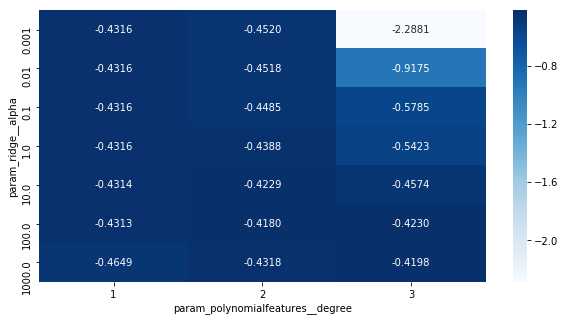

In [46]:
# グリッドサーチでのパラメータのラベル
degree="param_polynomialfeatures__degree"
alpha='param_ridge__alpha'

# 標準化と多項式特徴量とリッジ回帰モデルのパイプライン
pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), Ridge())

# ハイパーパラメータ（多項式の次数と正則化項の係数）
param_grid = {'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# グリッドサーチ
grid = GridSearchCV(pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, return_train_score=True, iid=False)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(-grid.best_score_)

# 可視化
results=pd.DataFrame(grid.cv_results_)
data=results[[degree, alpha, 'mean_test_score' ]].pivot(index=alpha, columns=degree, values='mean_test_score' )
plt.figure(figsize=(10,5))
sns.heatmap(data, annot=True, fmt='.4f',  cmap="Blues");

ハイパーパラメータの探索は以下のように`cross_val_score`を用いても行うことができます。

[cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [48]:
# ハイパーパラメータ（多項式の次数と正則化項の係数）
degree=[1,2,3]
alpha=[0.01, 0.1, 1, 10, 100]

print('次数', '正則化係数', '誤差')
for n in degree:
    for r in alpha:
        pipe = make_pipeline(PolynomialFeatures(degree=n), StandardScaler(), Ridge(alpha=r))
        scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
        print(n, r, '{:.3f}'.format(-scores.mean()))

次数 正則化係数 誤差
1 0.01 0.432
1 0.1 0.432
1 1 0.432
1 10 0.431
1 100 0.431
2 0.01 0.452
2 0.1 0.448
2 1 0.439
2 10 0.423
2 100 0.418
3 0.01 0.918
3 0.1 0.579
3 1 0.542
3 10 0.457
3 100 0.423


### テストデータによる評価

In [52]:
model = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), Ridge(alpha=100))
model.fit(X_train, y_train)

train_mse=mean_squared_error(y_train,model.predict(X_train))
print('訓練データ誤差 ', '{:.3f}'.format(train_mse))

test_mse=mean_squared_error(y_test,model.predict(X_test))
print('テストデータ誤差 ', '{:.3f}'.format(test_mse))

訓練データ誤差  0.400
テストデータ誤差  0.386


### ラッソ回帰（L1正則化）
以下では、$L_1$ノルムを正則化に用いた線形回帰モデルである`Lasso`（ラッソ回帰）を用いています。ラッソ回帰では多くのパラメータが0となるため疎なパラメータのモデルをえられます。

[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

{'lasso__alpha': 0.01, 'polynomialfeatures__degree': 3}
0.41937373249170273


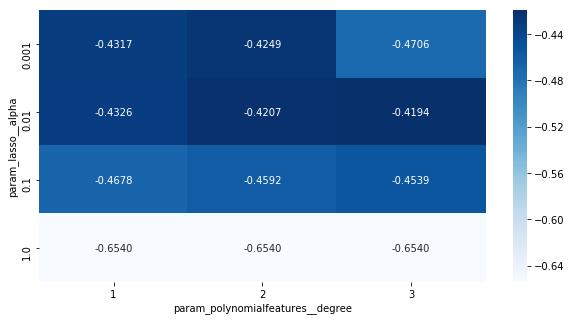

In [53]:
# グリッドサーチでのパラメータのラベル
degree="param_polynomialfeatures__degree"
alpha='param_lasso__alpha'

# 標準化と多項式特徴量とラッソ回帰モデルのパイプライン
pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), Lasso(max_iter=50000))

# ハイパーパラメータ（多項式の次数と正則化項の係数）
param_grid = {'polynomialfeatures__degree': [1, 2, 3], 'lasso__alpha': [0.001, 0.01, 0.1, 1]}

# グリッドサーチ
grid = GridSearchCV(pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, return_train_score=True, iid=False)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(-grid.best_score_)

# 可視化
results=pd.DataFrame(grid.cv_results_)
data=results[[degree, alpha, 'mean_test_score' ]].pivot(index=alpha, columns=degree, values='mean_test_score' )
plt.figure(figsize=(10,5))
sns.heatmap(data, annot=True, fmt='.4f',  cmap="Blues");

In [54]:
# パラメータ
#grid.best_estimator_.named_steps['lasso'].coef_

array([ 0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.00524848, -0.        ,
        0.        ,  0.03278787,  0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [55]:
# テストデータによる評価
model = make_pipeline(PolynomialFeatures(degree=3), StandardScaler(), Lasso(alpha=0.01, max_iter=50000))
model.fit(X_train, y_train)

train_mse=mean_squared_error(y_train,model.predict(X_train))
print('訓練データ誤差', '{:.3f}'.format(train_mse))

test_mse=mean_squared_error(y_test,model.predict(X_test))
print('テストデータ誤差', '{:.3f}'.format(test_mse))

訓練データ誤差 0.401
テストデータ誤差 0.393
